50
(46, 500)
(46,) (46,) (46,)


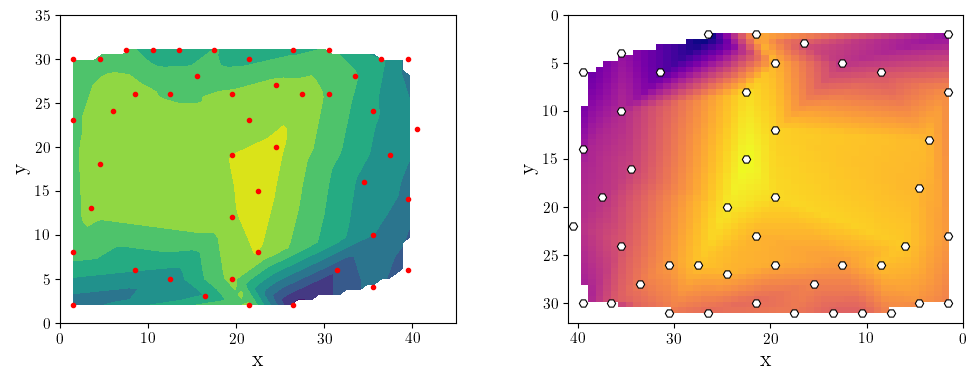

In [1]:
import numpy as onp
#import jax.numpy as np
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import rc
from scipy.interpolate import griddata

from scipy import stats

plt.rcParams.update(plt.rcParamsDefault)

plt.rc('font', family='serif')
plt.rcParams.update({'font.size': 11,
                     #'lines.linewidth': 2,
                     #'axes.labelsize': 20,  # fontsize for x and y labels (was 10)
                     #'axes.titlesize': 20,
                     #'xtick.labelsize': 16,
                     #'ytick.labelsize': 16,
                     #'legend.fontsize': 20,
                     #'axes.linewidth': 2,
                     "pgf.texsystem": "pdflatex",        # change this if using xetex or lautex
                     "text.usetex": True,                # use LaTeX to write all text
                     })

# Load the regrets

regrets_LCB_v = np.load("regrets_LCB_v.npy")
regrets_mean = np.load("regrets_mean.npy")
regrets_TS = np.load("regrets_TS.npy")
regrets_EI = np.load("regrets_EI.npy")
regrets_LW_LCB = np.load("regrets_LW_LCB.npy")
regrets_LCB = np.load("regrets_LCB.npy")
Weights_LW_LCB = np.load("Weights_LW_LCB.npy")
X_LW_LCB = np.load("X_LW_LCB.npy")


# Total number of iterations
T = regrets_LCB.shape[1]

print(T)

# load the data and the locations of sensors
Y_data = np.load("Data.npy")
xs = np.load("Locations.npy")

Y_data = np.array(Y_data)
xs = np.array(xs)
xs_orig = xs

# Total number of trials
T_max = regrets_LCB.shape[0]

# The data we use for training
Y_data = Y_data[:,0:T_max]

times = np.arange(T_max)


# Visualize the training data
#ax = plt.figure(1,figsize=(8,5))
##plt.title('Comparsion of different acquisition functions')
#plt.xticks(fontsize=15)
#plt.yticks(fontsize=15)
#for k in range(Y_data.shape[0]):
#    plt.plot(times, Y_data[k,:], linewidth=2)
#plt.xlabel('t',fontsize=20)
#plt.ylabel(r'Temperature',fontsize=20)
#plt.savefig('./Temperature_data.png', dpi = 200)


# Normalize the data and scale the inputs
lb = np.min(xs, axis = 0)
ub = np.max(xs, axis = 0)

xs = (xs - lb)/(ub - lb)

#print(xs)

Y_data = (Y_data - np.mean(Y_data)) / np.std(Y_data)


# See one sample of the data distribution
MC_samples = 500
nn = 50

# Locations for bandits
xx = np.linspace(0, 1, nn)
yy = np.linspace(0, 1, nn)
XX, YY = np.meshgrid(xx, yy)
X_positions = np.concatenate([XX.flatten()[:,None], YY.flatten()[:,None]], axis = 1)


print(Y_data.shape)


sigma = np.sqrt(1e-8) 
T = 50


print(xs[:,0].shape,xs[:,1].shape, Y_data[:,0].shape)

# interpolate
zi = griddata((xs[:,0], xs[:,1]), Y_data[:,0], (XX, YY), method='linear')

XX_orig = XX*(ub[0] - lb[0]) + lb[0] 
YY_orig = YY*(ub[1] - lb[1]) + lb[1] 

# Report median of regrets (log(R_T/T))
times = np.arange(T) + 1

regrets_LCB = np.cumsum(regrets_LCB, axis = 1) / times
regrets_LCB_v = np.cumsum(regrets_LCB_v, axis = 1) / times
regrets_mean = np.cumsum(regrets_mean, axis = 1) / times
regrets_TS = np.cumsum(regrets_TS, axis = 1) / times
regrets_EI = np.cumsum(regrets_EI, axis = 1) / times
regrets_LW_LCB = np.cumsum(regrets_LW_LCB, axis = 1) / times



dispersion_scale = 0.2

y1_mu, y1_std = np.median(regrets_LCB, axis = 0), stats.median_abs_deviation(regrets_LCB, axis = 0)
y2_mu, y2_std = np.median(regrets_mean, axis = 0), stats.median_abs_deviation(regrets_mean, axis = 0)
y4_mu, y4_std = np.median(regrets_TS, axis = 0), stats.median_abs_deviation(regrets_TS, axis = 0)
y5_mu, y5_std = np.median(regrets_EI, axis = 0), stats.median_abs_deviation(regrets_EI, axis = 0)
y6_mu, y6_std = np.median(regrets_LW_LCB, axis = 0), stats.median_abs_deviation(regrets_LW_LCB, axis = 0)
y7_mu, y7_std = np.median(regrets_LCB_v, axis = 0), stats.median_abs_deviation(regrets_LCB_v, axis = 0)


# maybe try to identify the location with log of temperature 

# plot
fig = plt.figure(-2, figsize = (12, 4))
ax = fig.add_subplot(121)
plt.contourf(XX_orig,YY_orig,zi)
plt.plot(xs_orig[:,0], xs_orig[:,1],'r.')
plt.xlabel('x',fontsize=16)
plt.ylabel('y',fontsize=16)
plt.axis('equal')
ax.set_aspect('equal', 'box')
plt.xlim(0,45)
plt.ylim(0,35)

ax = fig.add_subplot(122)
plt.imshow(zi, extent=[XX_orig.min(), XX_orig.max(), YY_orig.min(), YY_orig.max()], origin='lower', cmap='plasma')
plt.plot(xs_orig[:,0], xs_orig[:,1], 'H', markersize=6,
             markerfacecolor='white', markeredgecolor="k",
             markeredgewidth=0.8, linestyle='None')
plt.xlabel('x',fontsize=16)
plt.ylabel('y',fontsize=16)
plt.axis('equal')
ax.set_aspect('equal', 'box')
plt.xlim(0,41)
plt.ylim(0,32)
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()

plt.show()


In [2]:
plt.close("all")
plt.figure(figsize=(12*0.85/4,2.8*0.85))

ax = plt.subplot(111)
lower1 = np.log10(np.clip(y1_mu - dispersion_scale*y1_std, a_min=0., a_max = np.inf) + 1e-8)
upper1 = np.log10(y1_mu + dispersion_scale*y1_std + 1e-8)
plt.fill_between(times.flatten(), lower1.flatten(), upper1.flatten(), 
                 facecolor='C4', alpha=0.3) #, label="Two std band")
#lower2 = np.log10(np.clip(y2_mu - dispersion_scale*y2_std, a_min=0., a_max = np.inf) + 1e-8)
#upper2 = np.log10(y2_mu + dispersion_scale*y2_std + 1e-8)
#plt.fill_between(times.flatten(), lower2.flatten(), upper2.flatten(), 
#                 facecolor='green', alpha=0.5) #, label="Two std band")
lower4 = np.log10(np.clip(y4_mu - dispersion_scale*y4_std, a_min=0., a_max = np.inf) + 1e-8)
upper4 = np.log10(y4_mu + dispersion_scale*y4_std + 1e-8)
plt.fill_between(times.flatten(), lower4.flatten(), upper4.flatten(), 
                 facecolor='C1', alpha=0.3) #, label="Two std band")
lower5 = np.log10(np.clip(y5_mu - dispersion_scale*y5_std, a_min=0., a_max = np.inf) + 1e-8)
upper5 = np.log10(y5_mu + dispersion_scale*y5_std + 1e-8)
plt.fill_between(times.flatten(), lower5.flatten(), upper5.flatten(), 
                 facecolor='C0', alpha=0.3) #, label="Two std band")
lower6 = np.log10(np.clip(y6_mu - dispersion_scale*y6_std, a_min=0., a_max = np.inf) + 1e-8)
upper6 = np.log10(y6_mu + dispersion_scale*y6_std + 1e-8)
plt.fill_between(times.flatten(), lower6.flatten(), upper6.flatten(), 
                 facecolor='C3', alpha=0.3) #, label="Two std band")
lower7 = np.log10(np.clip(y7_mu - dispersion_scale*y7_std, a_min=0., a_max = np.inf) + 1e-8)
upper7 = np.log10(y7_mu + dispersion_scale*y7_std + 1e-8)
plt.fill_between(times.flatten(), lower7.flatten(), upper7.flatten(), 
                 facecolor='C2', alpha=0.3) #, label="Two std band")



#plt.plot(times,np.log10(y2_mu),'g-', label = "median of mean", linewidth=2)
plt.plot(times,np.log10(y5_mu),'C0-', label = "EI", linewidth=1)
plt.plot(times,np.log10(y4_mu),'C1-', label = "TS", linewidth=1)
plt.plot(times,np.log10(y7_mu),'C2', label = "V-UCB", linewidth=1)
plt.plot(times,np.log10(y1_mu),'C4', label = "GP-UCB", linewidth=1)
plt.plot(times,np.log10(y6_mu),'C3-', label = "LW-UCB", linewidth=1)



plt.xlim(0,50)
plt.ylim(-1.2, -0.2)
plt.xlabel(r'Round $t$')
plt.ylabel(r'$\log\,R_t/t$')
ax.set_xticks([0,25,50])
#ax.yaxis.set_label_coords(-0.15, 0.5)
plt.yticks([-1.2, -0.7, -0.2])
ax.tick_params(direction='in', length=2)
#plt.legend(loc='upper right', frameon=False, fontsize=9, labelspacing=0.2)#, borderaxespad=0.1)
plt.legend(loc='lower left', frameon=False, fontsize=9, labelspacing=0.2, borderaxespad=0.1, 
           handlelength=1.5, handletextpad=0.5)

plt.subplots_adjust(left=0.23, bottom=0.15, right=0.97, top=0.97, wspace=0, hspace=0)
plt.savefig('regret_temp.pdf')
exit()


In [3]:
# Generate 500 plots
Num_total = Weights_LW_LCB.shape[0]

#Num_total = 1

aspect_ratio = 467./900.

xmin, xmax = (0 - lb[0])/(ub[0] - lb[0]), (41 - lb[0])/(ub[0] - lb[0])
ymin, ymax = (0 - lb[1])/(ub[1] - lb[1]), (32 - lb[1])/(ub[1] - lb[1])


plt.close("all")
for k in range(Num_total):

    weights_plot = Weights_LW_LCB[k,:,:]
    X = X_LW_LCB[k,:,:]
    X = np.unique(X, axis=0)
    
    data = Y_data[:,k]

    zi = griddata((xs[:,0],xs[:,1]), data,(XX,YY), method='linear')

    plt.figure(figsize = (5, 1.5))
    
    ax1 = plt.subplot(121)
    plt.imshow(zi, extent=[XX.min(), XX.max(), YY.min(), YY.max()], 
               origin='lower', cmap='plasma', aspect=aspect_ratio)
    plt.plot(X[:,0], X[:,1], 'o', markersize=4,
             markerfacecolor='white', markeredgecolor="k",
             markeredgewidth=0.5, linestyle='None')
    #plt.axis('square')
    plt.xlim(xmin, xmax)
    plt.ylim(ymin, ymax)
    plt.gca().invert_xaxis()
    plt.gca().invert_yaxis()

    ax2 = plt.subplot(122)
    
    plt.imshow(weights_plot*0, extent=[XX.min(), XX.max(), YY.min(), YY.max()], 
               origin='lower', cmap='Blues', aspect=aspect_ratio)
    plt.contourf(XX, YY, weights_plot, cmap="Reds")
    
    plt.plot(X[:,0], X[:,1], 'o', markersize=4,
             markerfacecolor='none', markeredgecolor="k",
             markeredgewidth=0.5, linestyle='None')
    #plt.axis('square')
    plt.xlim(xmin, xmax)
    plt.ylim(ymin, ymax)
    plt.gca().invert_xaxis()
    plt.gca().invert_yaxis()

    
    for ax in (ax1, ax2):
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.tick_params(length=0)
        
    plt.subplots_adjust(left=0.01, bottom=0.01, right=0.99, top=0.98, wspace=0.05, hspace=0)
    #plt.tight_layout()
    
    plt.savefig('dip' + str(k) + '.pdf')
    
    

<ipython-input-3-7344d3714b84>:23: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize = (5, 1.5))
